In [441]:
import csv
import numpy as np
import math
import functools

%matplotlib inline
import matplotlib.pyplot as plt

In [442]:
distances = {
    'manhattan': lambda x, y: sum([abs(x[i] - y[i]) for i in range(len(x))]),
    'euclidean': lambda x, y: math.sqrt(sum([(x[i] - y[i]) ** 2 for i in range(len(x))])),
    'chebyshev': lambda x, y: max([abs(x[i] - y[i]) for i in range(len(x))]),
}

In [443]:
kernels = {
    'uniform': lambda x: 0.5 if abs(x) <= 1 else 0,
    'triangular': lambda x: 1 - abs(x) if abs(x) <= 1 else 0,
    'epanechnikov': lambda x: 3 / 4 * (1 - x ** 2) if abs(x) <= 1 else 0,
    'quartic': lambda x: 15 / 16 * (1 - x ** 2) ** 2 if abs(x) <= 1 else 0,
    'triweight': lambda x: 35 / 32 * (1 - x ** 2) ** 3 if abs(x) <= 1 else 0,
    'tricube': lambda x: 70 / 81 * (1 - abs(x) ** 3) ** 3 if abs(x) <= 1 else 0,
    'gaussian': lambda x: 1 / math.sqrt(2 * math.pi) * math.exp(-1 / 2 * x ** 2),
    'cosine': lambda x: math.pi / 4 * math.cos(math.pi / 2 * x) if abs(x) <= 1 else 0,
    'logistic': lambda x: 1 / (math.exp(x) + 2 + math.exp(-x)),
    'sigmoid': lambda x: 2 / math.pi / (math.exp(x) + math.exp(-x)),
}

In [444]:
def read_data():
    X, Y = [], []
    with open('wine.csv') as f:
        reader = csv.reader(f)
        data = np.array(list(reader))
        X = data[1:, 1:]
        Y = data[1:, :1]
        X = np.vectorize(float)(X)
        Y = np.vectorize(float)(Y)
    return X, Y

In [445]:
def normalize(data):
    for i in range(data.shape[1]):
        mn = min(data.T[i])
        mx = max(data.T[i])
        for j in range(data.shape[0]):
            data[j][i] = (data[j][i] - mn) / (mx - mn)
    return data

In [446]:
def predict_inner(query, X, Y, distType, kernelType, windowType, windowsWidth):
    n = X.shape[0]

    distance = distances[distType]
    kernel = kernels[kernelType]

    sortedX = sorted([distance(x, query) for x in X])

    if windowType == 'variable':
        windowsWidth = sortedX[windowsWidth]

    resY = 0
    res = 0
    for i in range(n):
        d = distance(X[i], query)
        t = 0
        if windowsWidth == 0:
            if d == 0:
                t = 1
        else:
            t = kernel(d / windowsWidth)
        res += t
        resY += t * Y[i]

    if res == 0:
        for i in range(n):
            resY += Y[i]
            res += 1

    result = resY / res

    return int(round(result))


In [447]:
def predict(X, Y, indexToQuery, distType, kernelType, windowType, windowsWidth):
    return predict_inner(X[indexToQuery],
                  np.delete(X, (indexToQuery), axis=0),
                  np.delete(Y, (indexToQuery), axis=0),
                  distType,
                  kernelType,
                  windowType,
                  windowsWidth)


In [448]:
# calc micro f score
def calc_f_score(confusion_matrix):
    k = confusion_matrix.shape[0]

    total_sum = sum(sum(confusion_matrix))

    def calc_f(tp, fn, fp, tn):
        p = tp + fn
        n = fp + tn
        rec = tp
        pr = tp
        if rec != 0:
            rec = tp / p
        if rec != 0:
            pr = tp / (tp + fp)
        if pr * rec == 0:
            return 0
        beta = 1
        f = (1 + beta * beta) * (pr * rec) / (beta * beta * pr + rec)
        return f

    def calc(x):
        tp = confusion_matrix[x][x]
        fn = sum(confusion_matrix[x]) - tp
        fp = sum(confusion_matrix.T[x]) - tp
        tn = total_sum - fn - fp + tp

        return calc_f(tp, fn, fp, tn)

    r = 0
    for i in range(k):
        t = calc(i)
        r += t * sum(confusion_matrix[i])
    return r / total_sum

In [449]:
def test_predict(X, Y, distType, kernelType, windowType, windowsWidth, addition_info=False):
    confusion_matrix = np.zeros([3, 3])
    for i in range(X.shape[0]):
        answer = predict(X, Y, i, distType, kernelType, windowType, windowsWidth)
        rounded_answer = int(round(answer))
        real_answer = int(Y[i])
        confusion_matrix[real_answer - 1][rounded_answer - 1] += 1

    f_score = calc_f_score(confusion_matrix)
    if addition_info:
        print(confusion_matrix)
        print("F-score", f_score)
    return f_score

In [450]:
XX, YY = read_data()
XX = normalize(XX)
YY = YY.flatten()

In [451]:
test_predict(XX, YY, 'euclidean', 'uniform', 'variable', 10, addition_info=True)


[[59.  0.  0.]
 [ 3. 65.  3.]
 [ 0.  0. 48.]]
F-score 0.9660128746456331


0.9660128746456331

In [452]:
def plot_f_score(distType, kernelType, windowType, values):
    T = []
    for i in values:
        f_score = test_predict(XX, YY, distType, kernelType, windowType, i)
        T.append((i, f_score))

    plt.plot([x for x, y in T], [y for x, y in T])
    plt.show()

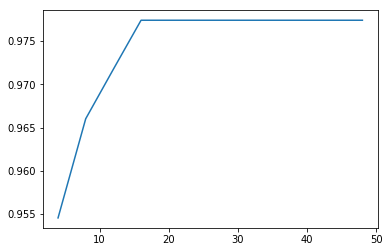

In [453]:
plot_f_score('euclidean', 'epanechnikov', 'variable', range(4, 50, 4))

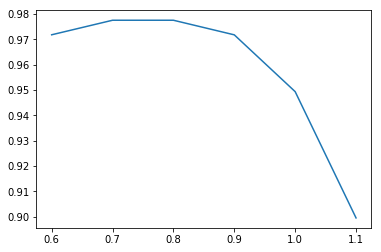

In [454]:
plot_f_score('euclidean', 'epanechnikov', 'fixed', map(lambda x: x/10, range(6, 12)))


In [455]:
def draw_plot(dataset, datasetRes, feature1N, feature2N, target):
    vine_class = {
        1: "g",
        2: "b",
        3: "y"
    }

    colored = list(map(lambda x: vine_class[int(x)], datasetRes))
    colored.append("r")

    x = list(dataset[:, feature1N])
    y = list(dataset[:, feature2N])

    x.append(target[feature1N])
    y.append(target[feature2N])

    plt.scatter(x, y, c=colored)
    plt.show()


In [456]:
def drawDot(ind, feature1N, feature2N, distType, kernelType, windowType, windowsWidth):
    pr = predict(XX, YY, ind, distType, kernelType, windowType, windowsWidth)
    draw_plot(np.delete(XX, (ind), axis=0),
              np.delete(YY, (ind), axis=0),
              feature1N,
              feature2N,
              XX[ind])
    print('Predicted:', pr)
    print('Real:', YY[ind])


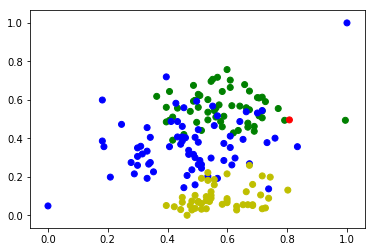

Predicted: 1
Real: 1.0


In [457]:
drawDot(4, 2, 6, 'euclidean', 'epanechnikov', 'variable', 20)


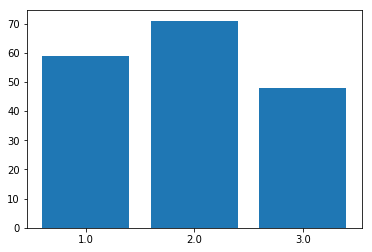

In [458]:
def _t(acc, elem):
    if acc.get(elem) is None :
        acc[elem] = 0
    acc[elem] += 1
    return acc

D = functools.reduce(_t, YY.flatten(), {})


plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))

plt.show()